In [1]:
import sys
sys.path.insert(0, "../")
from tmds import *
import os
%matplotlib inline

2.7.12 (default, Nov 12 2018, 14:36:49) 
[GCC 5.4.0 20160609]


In [32]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.utils import resample
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [33]:
s = ["CHA", "SFA-Ctk", "SFA-Pw", "SHA-Ctk", "SHA-Pw", "SRHA"]
cities = ["a", "b", "c", "d", "e"]

In [34]:
df = pd.read_csv("data.csv", "\t")
df["abundance"] = np.log(df["abundance"])
df["H/C"] = df["H"] / df["C"]
df["O/C"] = df["O"] / df["C"]
df["DBE"] = df["C"] - df["H"]/2 + df["N"]/2 + 1
df.sample(10)

,exp,town,abundance,mw,error,C,H,O,N,S,y,H/C,O/C,DBE
46997,SFA-Ctk,e,-2.332676,392.016936,0.265246,20,8,9,0,0,5,0.400000,0.450000,17.0
16550,CHA,e,-3.085463,614.048626,0.162591,34,14,12,0,0,3,0.411765,0.352941,28.0
63289,SFA-Pw,b,-4.035404,478.195316,0.387179,23,30,9,2,0,1,1.304348,0.391304,10.0
52529,SFA-Pw,a,-5.821737,864.232476,0.060550,39,44,22,0,0,2,1.128205,0.564103,18.0
30540,SFA-Ctk,a,-5.331487,411.137686,0.025349,15,25,12,1,0,2,1.666667,0.800000,4.0
21689,CHA,e,-3.871807,504.230036,-0.047016,34,32,4,0,0,1,0.941176,0.117647,19.0
67729,SFA-Pw,c,-4.317279,528.147826,-0.151395,23,28,14,0,0,5,1.217391,0.608696,10.0
72370,SFA-Pw,d,-3.803796,490.314026,-0.321070,25,46,9,0,0,2,1.840000,0.360000,3.0
85373,SHA-Ctk,b,-6.298240,440.350196,0.047828,26,48,5,0,0,1,1.846154,0.192308,3.0
75425,SFA-Pw,d,-3.686650,630.070676,0.368884,24,22,20,0,0,2,0.916667,0.833333,14.0


In [35]:
db = pd.get_dummies(df[["town", "abundance", "H/C", "O/C", "N", "S", "DBE", "mw", "error", "y"]])
db["exp"] = df["exp"]
db["y"] = (db["y"] >= 4) * 1
db["town"] = df["town"]
db.sample(5)

,abundance,H/C,O/C,N,S,DBE,mw,error,y,town_a,town_b,town_c,town_d,town_e,exp,town
134651,-3.250315,1.333333,0.454545,0,0,12.0,680.268216,0.286371,0,0,0,0,0,1,SRHA,e
128638,-3.961367,0.888889,0.333333,0,0,11.0,328.094676,-0.037779,1,0,0,1,0,0,SRHA,c
403,-7.779767,0.444444,0.277778,0,0,29.0,608.074396,0.080656,0,1,0,0,0,0,CHA,a
22010,-3.938098,0.645161,0.258065,2,0,23.0,548.121796,-0.309864,0,0,0,0,0,1,CHA,e
27863,-5.148635,0.583333,0.750000,1,0,10.0,309.012066,-0.048516,1,1,0,0,0,0,SFA-Ctk,a


In [36]:
len(db)

138385

In [37]:
db.exp.unique()
#['CHA', 'SFA-Ctk', 'SFA-Pw', 'SHA-Ctk', 'SHA-Pw', 'SRHA']
#I will not use CHA, SHA-Ctk
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
model = Pipeline([("ss", SS()), ("svm", LR())])

ans = []

for i in range(4):
    train = filter(lambda x: x != exps[i], exps)
    train = pd.concat(list(map(lambda x: db[db["exp"] == x], train)))
    
    one = train[train["y"] == 1]
    zer = train[train["y"] == 0]
    print(len(one))
    print(len(zer))
    tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
    
    
    test = db[db["exp"] == exps[i]]
    
    print "fitting..."
    model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    print "scoring..."
    print exps[i]
    
    ans.append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
    print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
    print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
    print "test:            ", f1_score(ans[-1], test["y"])
    
    
    

36944
38368
fitting...
scoring...
SFA-Ctk
balanced train:   0.772643352153
unbalanced train: 0.771538882877
test:             0.734523104265
33774
39342
fitting...
scoring...
SFA-Pw
balanced train:   0.763993482186
unbalanced train: 0.750086475268
test:             0.776864111498
37780
43406
fitting...
scoring...
SHA-Pw
balanced train:   0.799989552863
unbalanced train: 0.787089977001
test:             0.570202808112
36969
44181
fitting...
scoring...
SRHA
balanced train:   0.783851574631
unbalanced train: 0.766398069213
test:             0.773811004685


In [38]:
db["y_pred"] = 0
for i in range(4):
    db.loc[db["exp"] == exps[i], "y_pred"] = ans[i]

In [39]:
data_1 = []
for i in range(4):
    data_1.append([])
    for j in range(5):
        data_1[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & (db["y"] == 1) & (df["town"] == cities[j])][elems].values))

In [40]:
for i in range(4):
    for j in range(5):
        print len(data_1[i][j])

2518
1865
2171
2514
2477
3145
3039
2619
3031
2881
1842
2127
2168
2258
2314
2507
2554
1415
2527
2517


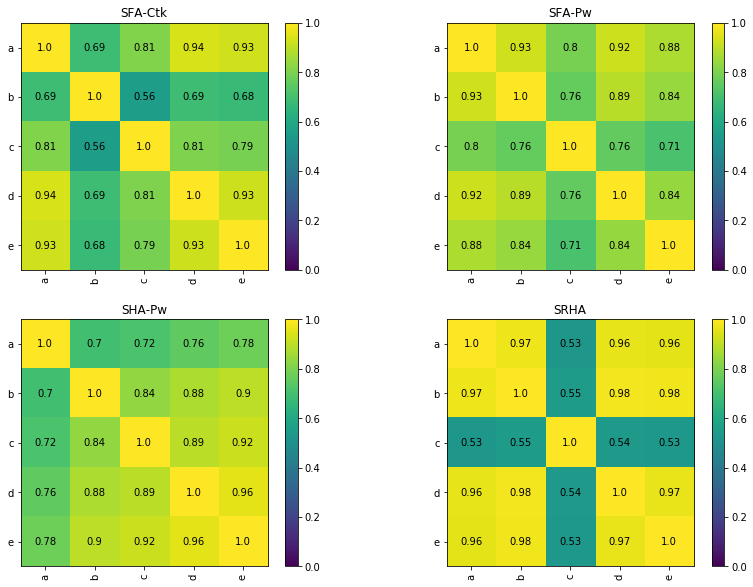

In [41]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_1[e][i], data_1[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [42]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

In [43]:
data = []
for i in range(4):
    data.append([])
    for j in range(5):
        data[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & 
                                                             (df["town"] == cities[j]) & 
                                                             (df["y"] > 0)][elems].values))

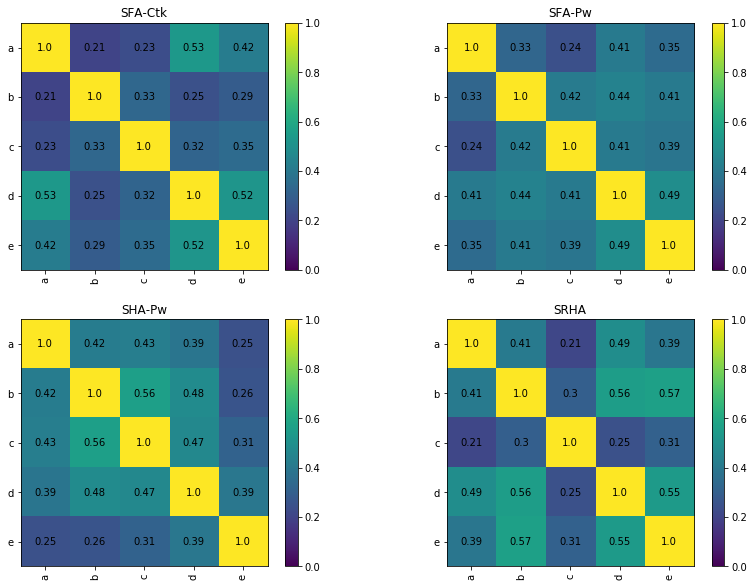

In [44]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data[e][i], data[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

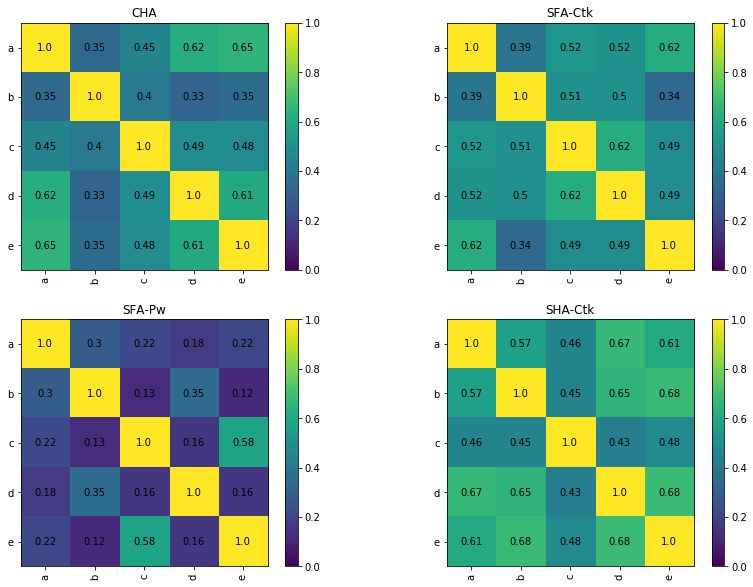

In [45]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(s[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [46]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", LR())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

7494
13052
balanced train:   0.854735733562
unbalanced train: 0.803887582023
test:             0.709158415842
6867
11978
balanced train:   0.838405486498
unbalanced train: 0.785910399786
test:             0.752929360562
8170
18302
balanced train:   0.858135633837
unbalanced train: 0.782048482201
test:             0.692241626109
7505
15822
balanced train:   0.841798393366
unbalanced train: 0.761575430782
test:             0.804828289697
7720
4971
balanced train:   0.753762950414
unbalanced train: 0.786885245902
test:             0.833289714734
6546
4037
balanced train:   0.745052566481
unbalanced train: 0.7806577029
test:             0.831425435158
7458
5826
balanced train:   0.805366439728
unbalanced train: 0.823730202075
test:             0.162278808804
7031
4267
balanced train:   0.78099459759
unbalanced train: 0.819893841344
test:             0.718257261411
6202
2123
balanced train:   0.778942315385
unbalanced train: 0.841195783653
test:             0.871003307607
5754
1884
balanced

In [47]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [48]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

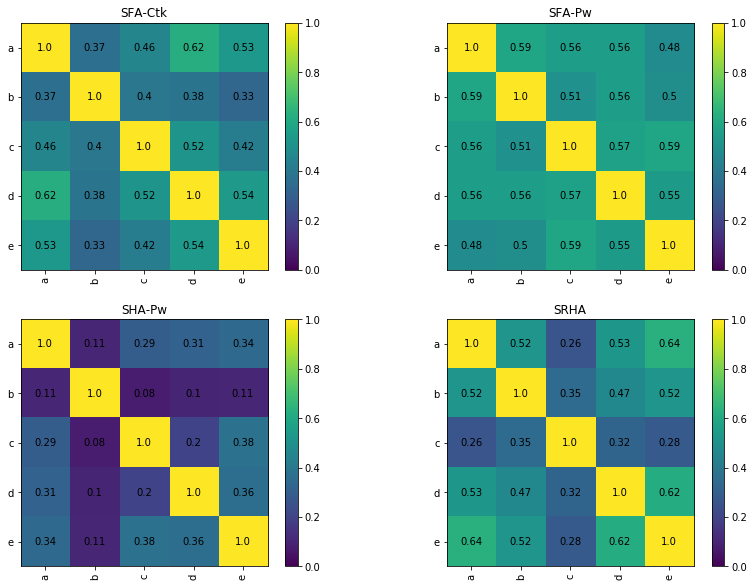

In [49]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [24]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", SVC())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

10186
10360
balanced train:   0.887898459452
unbalanced train: 0.885367856625
test:             0.821057288211
10102
8743
balanced train:   0.873649738501
unbalanced train: 0.881491344874
test:             0.785290915689
12276
14196
balanced train:   0.886101314524
unbalanced train: 0.874051233397
test:             0.77416481069
11203
12124
balanced train:   0.875965627984
unbalanced train: 0.868801652893
test:             0.821690140845
9784
2907
balanced train:   0.886086591005
unbalanced train: 0.913641781341
test:             0.884700122399
8229
2354
balanced train:   0.890403251016
unbalanced train: 0.916532595405
test:             0.928126621692
9573
3711
balanced train:   0.893252183117
unbalanced train: 0.919331118253
test:             0.4540302267
8465
2833
balanced train:   0.909865656625
unbalanced train: 0.936867763559
test:             0.732213951878
7111
1214
balanced train:   0.911610540676
unbalanced train: 0.937873975031
test:             0.951282561145
6682
956
balanc

In [25]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [26]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

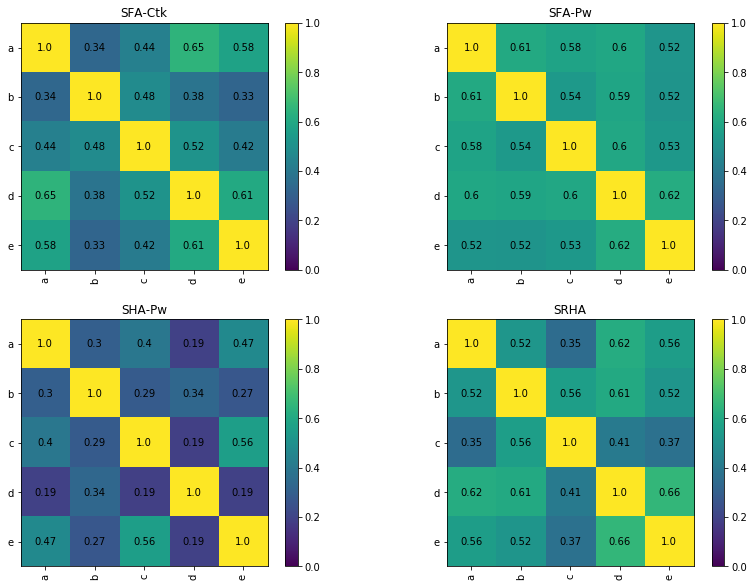

In [27]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})